# Imports and Settings

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense
from tensorflow.keras.losses import BinaryCrossentropy, MeanSquaredError, MeanAbsoluteError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns

In [ ]:
gpu_devices = tf.config.experimental.list_physical_devices('GPU')
if gpu_devices:
    print('Using GPU')
    tf.config.experimental.set_memory_growth(gpu_devices[0], True)
else:
    print('Using CPU')

Using CPU


In [ ]:
sns.set_style('white')

In [ ]:
np.random.seed(42)
tf.random.set_seed(1234)

In [ ]:
path = Path('time_gan')
hdf_store = path / 'TimeSeriesGAN.h5'

In [ ]:
seq_len = 8
n_seq = 26

# Load Data

In [ ]:
experiment = 0

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
real_data_path = '/content/drive/MyDrive/BBG Capstone Summer 2023/Data/timeGAN_data.csv'

def get_real_data():
    df = pd.read_csv(real_data_path)
    df['Dates'] = pd.to_datetime(df['Dates'], infer_datetime_format=True)
    df.set_index(zip(df['Unnamed: 0'], df['Dates']), inplace=True)
    df.drop(columns = ['Unnamed: 0', 'Dates'], inplace = True)

    # Preprocess the dataset:
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(df)
    stocks = df.index.get_level_values(0).unique()
    n_stocks = len(stocks)
    total_timesteps = len(df.loc[stocks[0], :])
    features = len(df.columns)
    df_array = df.values.reshape((n_stocks, total_timesteps, features))

    data = []
    for stock_arr in df_array:
      for i in range(len(stock_arr) - seq_len):
        data.append(scaled_data[i: i + seq_len])
    return data


real_data = get_real_data()

In [ ]:
n = len(real_data)

In [ ]:
np.asarray(real_data).shape

(4450, 8, 26)

In [ ]:
gen_data_path = '/content/drive/MyDrive/BBG Capstone Summer 2023/Runs/first_run/time_gan'

synthetic_data = np.load(gen_data_path + '/' + f'experiment_{experiment:02d}' + '/' + 'generated_data.npy')
synthetic_data.shape

(4352, 8, 26)

In [ ]:
real_data = real_data[:synthetic_data.shape[0]]

# Prepare Sample

In [ ]:
sample_size = 250
idx = np.random.permutation(len(real_data))[:sample_size]

In [ ]:
# Data preprocessing
real_sample = np.asarray(real_data)[idx]
synthetic_sample = np.asarray(synthetic_data)[idx]

In [ ]:
real_sample_2d = real_sample.reshape(-1, seq_len)
synthetic_sample_2d = synthetic_sample.reshape(-1, seq_len)

In [ ]:
real_sample_2d.shape, synthetic_sample_2d.shape

((6500, 8), (6500, 8))

# Visualization in 2D: A Qualitative Assessment of Diversity

## PCA

In [ ]:
pca = PCA(n_components=2)
pca.fit(real_sample_2d)
pca_real = (pd.DataFrame(pca.transform(real_sample_2d))
            .assign(Data='Real'))
pca_synthetic = (pd.DataFrame(pca.transform(synthetic_sample_2d))
                 .assign(Data='Synthetic'))
pca_result = pca_real.append(pca_synthetic).rename(
    columns={0: '1st Component', 1: '2nd Component'})

<ipython-input-22-6d9674967aa6>:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  pca_result = pca_real.append(pca_synthetic).rename(


## t-SNE

t-SNE is a non-linear manifold learning method for the visualization of high-dimensional data. It converts similarities between data points to joint probabilities and aims to minimize the Kullback-Leibler divergence between the joint probabilities of the low-dimensional embedding and the high-dimensional data. We compute t-SNE for the combined real and synthetic data as follows:

In [ ]:
tsne_data = np.concatenate((real_sample_2d,
                            synthetic_sample_2d), axis=0)

tsne = TSNE(n_components=2,
            verbose=1,
            perplexity=40)
tsne_result = tsne.fit_transform(tsne_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 13000 samples in 0.021s...
[t-SNE] Computed neighbors for 13000 samples in 0.503s...
[t-SNE] Computed conditional probabilities for sample 1000 / 13000
[t-SNE] Computed conditional probabilities for sample 2000 / 13000
[t-SNE] Computed conditional probabilities for sample 3000 / 13000
[t-SNE] Computed conditional probabilities for sample 4000 / 13000
[t-SNE] Computed conditional probabilities for sample 5000 / 13000
[t-SNE] Computed conditional probabilities for sample 6000 / 13000
[t-SNE] Computed conditional probabilities for sample 7000 / 13000
[t-SNE] Computed conditional probabilities for sample 8000 / 13000
[t-SNE] Computed conditional probabilities for sample 9000 / 13000
[t-SNE] Computed conditional probabilities for sample 10000 / 13000
[t-SNE] Computed conditional probabilities for sample 11000 / 13000
[t-SNE] Computed conditional probabilities for sample 12000 / 13000
[t-SNE] Computed conditional probabilities for sa

In [ ]:
tsne_result = pd.DataFrame(tsne_result, columns=['X', 'Y']).assign(Data='Real')
tsne_result.loc[sample_size*6:, 'Data'] = 'Synthetic'

## Plot Result

The below figure displays the PCA and t-SNE results for a qualitative assessment of the similarity of the real and synthetic data distributions.

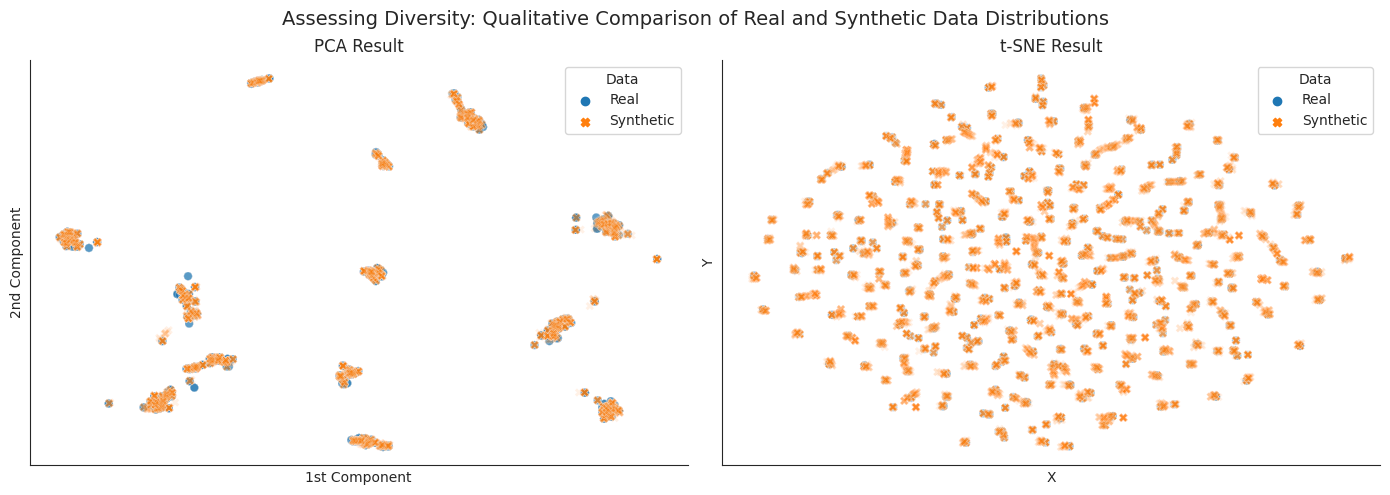

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 5))

sns.scatterplot(x='1st Component', y='2nd Component', data=pca_result,
                hue='Data', style='Data', ax=axes[0], alpha = 0.1)
sns.despine()
axes[0].set_title('PCA Result')


sns.scatterplot(x='X', y='Y',
                data=tsne_result,
                hue='Data',
                style='Data',
                ax=axes[1], alpha = 0.1)
sns.despine()
for i in [0, 1]:
    axes[i].set_xticks([])
    axes[i].set_yticks([])

axes[1].set_title('t-SNE Result')
fig.suptitle('Assessing Diversity: Qualitative Comparison of Real and Synthetic Data Distributions',
             fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.88);

The visualization only provides a qualitative impression. For a quantitative assessment of the fidelity of the synthetic data, we train a time-series classifier to distinguish between real and fake data and evaluate its performance on a held-out test set.

More specifically, we select the first 80 percent of the rolling sequences for training, and the last 20 percent as test set as follows:

## Prepare Data

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]
real_data.shape

(4352, 8, 26)

In [ ]:
synthetic_data.shape

(4352, 8, 26)

In [ ]:
n_series = real_data.shape[0]

In [ ]:
idx = np.arange(n_series)

In [ ]:
n_train = int(.8*n_series)
train_idx = idx[:n_train]
test_idx = idx[n_train:]

In [ ]:
train_data = np.vstack((real_data[train_idx],
                        synthetic_data[train_idx]))
test_data = np.vstack((real_data[test_idx],
                       synthetic_data[test_idx]))

In [ ]:
n_train, n_test = len(train_idx), len(test_idx)
train_labels = np.concatenate((np.ones(n_train),
                               np.zeros(n_train)))
test_labels = np.concatenate((np.ones(n_test),
                              np.zeros(n_test)))

## Classifier

Then we create a simple RNN with six units that receives mini batches of real and synthetic series of shape 8 ⨉ 26 and uses a sigmoid activation. We optimize it using binary cross entropy loss and the Adam optimizer while tracking the AUC and accuracy metrics:

In [ ]:
ts_classifier = Sequential([GRU(6, input_shape=(8, 26), name='GRU'),
                            Dense(1, activation='sigmoid', name='OUT')],
                           name='Time_Series_Classifier')

In [ ]:
ts_classifier.compile(loss='binary_crossentropy',
                      optimizer='adam',
                      metrics=[AUC(name='AUC'), 'accuracy'])

In [ ]:
ts_classifier.summary()

Model: "Time_Series_Classifier"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 GRU (GRU)                   (None, 6)                 612       
                                                                 
 OUT (Dense)                 (None, 1)                 7         
                                                                 
Total params: 619
Trainable params: 619
Non-trainable params: 0
_________________________________________________________________


In [ ]:
result = ts_classifier.fit(x=train_data,
                           y=train_labels,
                           validation_data=(test_data, test_labels),
                           epochs=250,
                           batch_size=128,
                           verbose=0)

In [ ]:
ts_classifier.evaluate(x=test_data, y=test_labels)

55/55 [==============================] - 0s 3ms/step - loss: 0.4616 - AUC: 0.8972 - accuracy: 0.7589


[0.4615505635738373, 0.8972004055976868, 0.7588978409767151]

In [ ]:
history = pd.DataFrame(result.history)
history.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250 entries, 0 to 249
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   loss          250 non-null    float64
 1   AUC           250 non-null    float64
 2   accuracy      250 non-null    float64
 3   val_loss      250 non-null    float64
 4   val_AUC       250 non-null    float64
 5   val_accuracy  250 non-null    float64
dtypes: float64(6)
memory usage: 11.8 KB


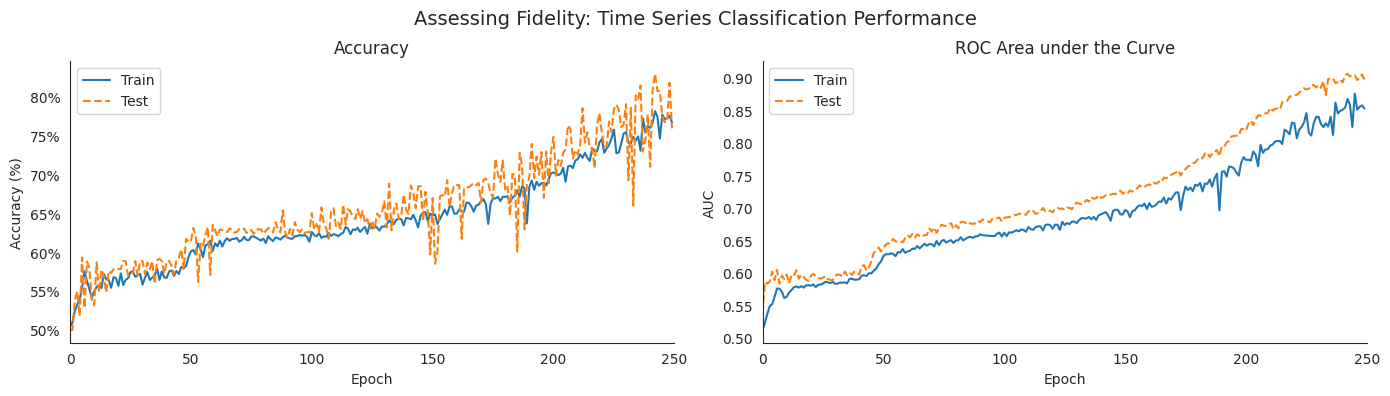

In [ ]:
sns.set_style('white')
fig, axes = plt.subplots(ncols=2, figsize=(14,4))
history[['AUC', 'val_AUC']].rename(columns={'AUC': 'Train', 'val_AUC': 'Test'}).plot(ax=axes[1],
                                                                                     title='ROC Area under the Curve',
                                                                                    style=['-', '--'],
                                                                                    xlim=(0, 250))
history[['accuracy', 'val_accuracy']].rename(columns={'accuracy': 'Train', 'val_accuracy': 'Test'}).plot(ax=axes[0],
                                                                                                         title='Accuracy',
                                                                                                        style=['-', '--'],
                                                                                                        xlim=(0, 250))
for i in [0, 1]:
    axes[i].set_xlabel('Epoch')

axes[0].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))
axes[0].set_ylabel('Accuracy (%)')
axes[1].set_ylabel('AUC')
sns.despine()
fig.suptitle('Assessing Fidelity: Time Series Classification Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);

## Prepare Data

In [ ]:
real_data = get_real_data()
real_data = np.array(real_data)[:len(synthetic_data)]

In [ ]:
real_data.shape, synthetic_data.shape

((4352, 8, 26), (4352, 8, 26))

In [ ]:
real_train_data = real_data[train_idx, :7, :]
real_train_label = real_data[train_idx, -1, :]

real_test_data = real_data[test_idx, :7, :]
real_test_label = real_data[test_idx, -1, :]

In [ ]:
real_train_data.shape, real_train_label.shape, real_test_data.shape, real_test_label.shape

((3481, 7, 26), (3481, 26), (871, 7, 26), (871, 26))

In [ ]:
synthetic_train = synthetic_data[:, :7, :]
synthetic_label = synthetic_data[:, -1, :]

In [ ]:
synthetic_train.shape, synthetic_label.shape

((4352, 7, 26), (4352, 26))

We create a one-layer RNN with 12 GRU units that predicts the last time steps for the 26 financial features and, thus, has 26 linear output units. The model uses the Adam optimizer to minimize the mean absolute error (MAE):

In [ ]:
def get_model():
    model = Sequential([GRU(12,
                            input_shape=(seq_len-1,
                                         n_seq)),
                        Dense(26)])

    model.compile(optimizer=Adam(),
                  loss=MeanAbsoluteError(name='MAE'))
    return model

## Train model

We train the model twice using the synthetic and real data for training, respectively, and the real test set to evaluate the out-of-sample performance. Training on synthetic data works as follows, training on real data works analogously:

In [ ]:
ts_regression = get_model()
synthetic_result = ts_regression.fit(x=synthetic_train,
                                     y=synthetic_label,
                                     validation_data=(
                                         real_test_data,
                                         real_test_label),
                                     epochs=100,
                                     batch_size=128,
                                     verbose=0)

In [ ]:
synthetic_result = pd.DataFrame(synthetic_result.history).rename(columns={'loss': 'Train',
                                                                          'val_loss': 'Test'})

In [ ]:
ts_regression = get_model()
real_result = ts_regression.fit(x=real_train_data,
                                y=real_train_label,
                                validation_data=(
                                    real_test_data,
                                    real_test_label),
                                epochs=100,
                                batch_size=128,
                                verbose=0)

In [ ]:
real_result = pd.DataFrame(real_result.history).rename(columns={'loss': 'Train',
                                                                'val_loss': 'Test'})

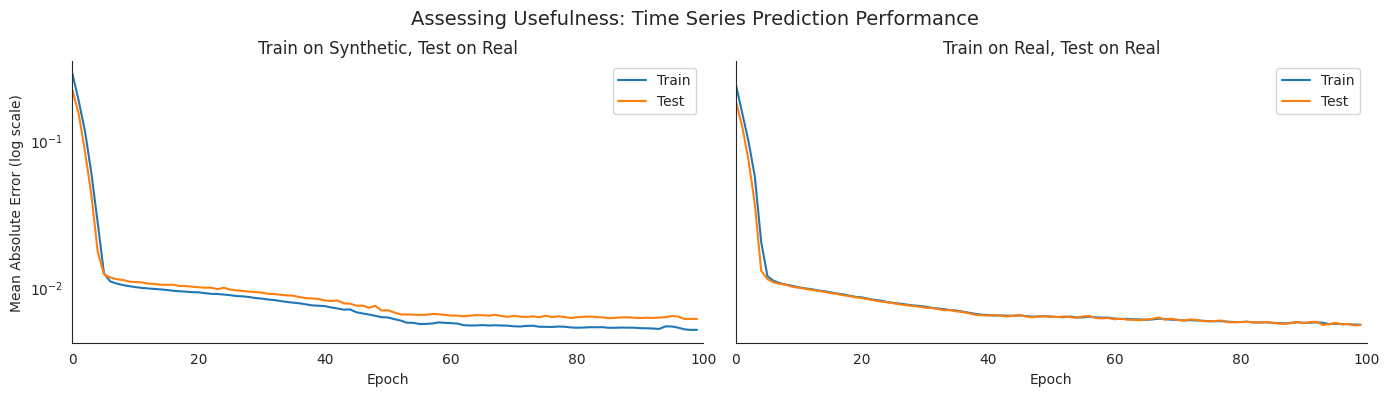

In [ ]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4), sharey=True)

synthetic_result.plot(ax=axes[0], title='Train on Synthetic, Test on Real',
                      logy=True,
                      xlim=(0, 100))
real_result.plot(ax=axes[1], title='Train on Real, Test on Real',
                 logy=True,
                 xlim=(0, 100))

for i in [0, 1]:
    axes[i].set_xlabel('Epoch')
    axes[i].set_ylabel('Mean Absolute Error (log scale)')

sns.despine()
fig.suptitle('Assessing Usefulness: Time Series Prediction Performance', fontsize=14)
fig.tight_layout()
fig.subplots_adjust(top=.85);